In [65]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [66]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training BKK with *minimal_SARIMAX*

In [67]:
import sys
sys.path.append('../')

In [68]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [69]:
train_set = pd.read_csv('6Hsampled_data_set/BKK/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/BKK/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/BKK/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [70]:
order = (2, 0, 2)
seasonal_order = (1, 1, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 1)
exog_order['WindSpeed'] = (2, 0, 2)
exog_order['WindDirSin'] = (0, 1, 1)
exog_order['WindDirCos'] = (2, 0, 0)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 0, 0, 1461)
exog_seasonal_order['WindSpeed'] = (0, 0, 1, 1461)
exog_seasonal_order['WindDirSin'] = (1, 0, 1, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [71]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [72]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.9995, lr_decay_iter=0.75,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 4383/4383 [03:51<00:00, 18.96it/s]


ITER#0  RMSE:3.9516022924786633


100%|██████████| 4383/4383 [03:53<00:00, 18.80it/s]


ITER#0  RMSE:9.004393132661484


100%|██████████| 4383/4383 [03:51<00:00, 18.94it/s]


ITER#0  RMSE:11.658932944974065


100%|██████████| 4383/4383 [03:56<00:00, 18.51it/s]

ITER#0  RMSE:10.27977334771844


#### Bangkok

In [73]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([1e-6, 0, 0, 0, 0]), lr_decay=0.9995, lr_decay_iter=0.75,
                                  step=12, n_iter=1, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [15:20<00:00,  4.76it/s]

ITER#0  RMSE:12.21926501836844


In [74]:
model.params

{'p': array([0.28534703, 0.28841232]),
 'pX': array([0.1385093 , 0.07205267, 0.04535648, 0.05074272]),
 'd': array([0.]),
 'q': array([0.1322027 , 0.13500987]),
 'P': array([0.09641871]),
 'D': array([0.1846941]),
 'Q': array([0.08572721]),
 'c': 0.10558412291708871}

In [80]:
with open('../model_save/model_bkk.model',"wb") as f:
    pickle.dump(model, f)

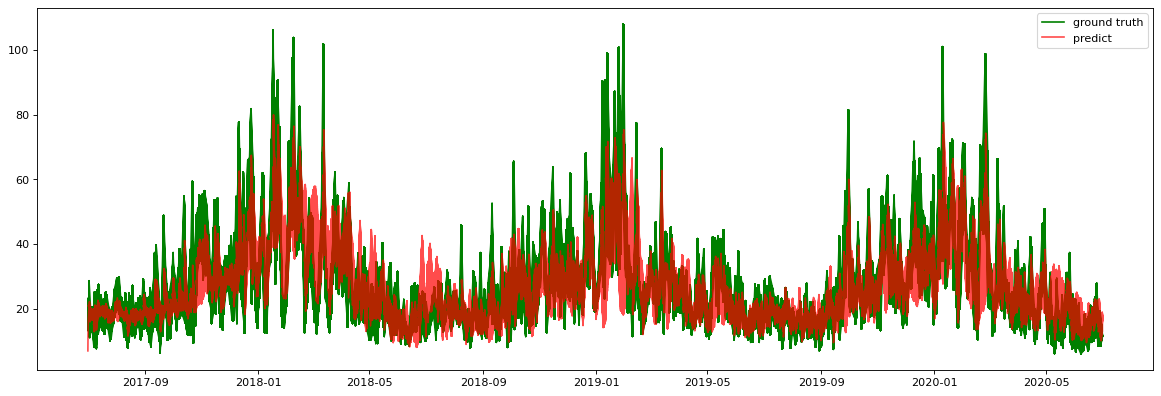

In [76]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [77]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([1e-6, 1e-6, 1e-6, 1e-6, 1e-6]), lr_decay=0.999,
                                 step=12, n_iter=1, learn=False, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [08:11<00:00,  5.66it/s]

ITER#0  RMSE:11.40875545726429


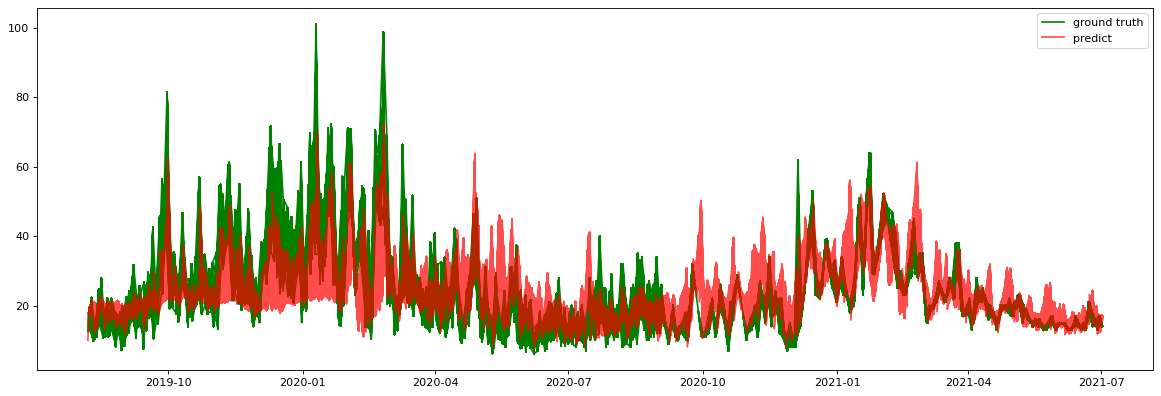

In [82]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [81]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_BKK.csv')